In [78]:
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [79]:
## Load the data
filenames = glob.glob("ETFs" + "/*.csv")
print(filenames)

df = pd.read_csv(filenames[0])
df["ETFs_index"] = 0
count = 1
for file in filenames:
    if (count >= 100):
        break
    
    try:
        cur_df = pd.read_csv(file)
        cur_df["ETFs_index"] = count
        df = pd.concat([df, cur_df], ignore_index=True)
        count += 1
    except Exception as e:
        print(f"Error reading {file}: {e}")

df.to_csv("raw_data2.csv", index=False)

['ETFs/jjm.us.csv', 'ETFs/schg.us.csv', 'ETFs/xrt.us.csv', 'ETFs/ivv.us.csv', 'ETFs/dsum.us.csv', 'ETFs/dbem.us.csv', 'ETFs/fgb.us.csv', 'ETFs/tlt.us.csv', 'ETFs/mchi.us.csv', 'ETFs/bsji.us.csv', 'ETFs/gaa.us.csv', 'ETFs/iwx.us.csv', 'ETFs/frn.us.csv', 'ETFs/grn.us.csv', 'ETFs/amjl.us.csv', 'ETFs/cly.us.csv', 'ETFs/hgi.us.csv', 'ETFs/eny.us.csv', 'ETFs/rdvy.us.csv', 'ETFs/fam.us.csv', 'ETFs/grwn.us.csv', 'ETFs/ige.us.csv', 'ETFs/chix.us.csv', 'ETFs/qyld.us.csv', 'ETFs/qjpn.us.csv', 'ETFs/iqde.us.csv', 'ETFs/tmv.us.csv', 'ETFs/egpt.us.csv', 'ETFs/xph.us.csv', 'ETFs/fcor.us.csv', 'ETFs/ryh.us.csv', 'ETFs/jja.us.csv', 'ETFs/dxjs.us.csv', 'ETFs/pfm.us.csv', 'ETFs/qlta.us.csv', 'ETFs/vioo.us.csv', 'ETFs/rzv.us.csv', 'ETFs/fta.us.csv', 'ETFs/eema.us.csv', 'ETFs/xbi.us.csv', 'ETFs/qqq.us.csv', 'ETFs/kold.us.csv', 'ETFs/hyzd.us.csv', 'ETFs/xpp.us.csv', 'ETFs/nfo.us.csv', 'ETFs/iwl.us.csv', 'ETFs/iemg.us.csv', 'ETFs/fbnd.us.csv', 'ETFs/fndf.us.csv', 'ETFs/gvi.us.csv', 'ETFs/ashr.us.csv', 'ETFs/

In [80]:
df = pd.read_csv("raw_data2.csv")

In [81]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt,ETFs_index
count,185316.000000,185316.000000,185316.000000,185316.000000,1.853160e+05,185316.0,185316.000000
mean,50.454451,50.916700,49.988340,50.435286,2.718740e+06,0.0,47.904806
std,156.410407,160.255504,153.329789,156.456047,1.591204e+07,0.0,29.197478
min,1.003000,1.068300,0.986500,0.986500,0.000000e+00,0.0,0.000000
25%,20.016000,20.123750,19.884000,20.008750,6.978750e+03,0.0,22.000000
50%,32.174000,32.389000,31.936500,32.174000,3.101200e+04,0.0,45.000000
75%,53.500000,53.800250,53.159250,53.480000,1.859185e+05,0.0,73.000000
max,6262.000000,6397.000000,5770.500000,6159.500000,6.755370e+08,0.0,99.000000


In [82]:
df["next_day"] = df["Close"].shift(-1)

df["target"] = (df["next_day"] > df["Close"]).astype(int)

df = df.sort_values(by="Date")

df = df.drop("OpenInt", axis=1)

df.set_index("Date", inplace=True)

# df["Target"] = (df.groupby('Date')["daily_avg_close"].shift(-1) > df.groupby('Date')["daily_avg_close"]).astype(int)
df = df.dropna()

df


,Open,High,Low,Close,Volume,ETFs_index,next_day,target
Date,,,,,,,,
1999-03-10,45.7220,45.7500,44.967,45.6650,11700414,41,45.880,1
1999-03-11,45.9940,46.2600,44.988,45.8800,21670048,41,44.770,0
1999-03-12,45.7210,45.7490,44.406,44.7700,19553768,41,46.052,1
1999-03-15,45.1010,46.1030,44.625,46.0520,14245348,41,46.447,1
1999-03-16,46.2530,46.6430,45.749,46.4470,10971066,41,46.106,0
...,...,...,...,...,...,...,...,...
2017-11-10,50.7500,50.7500,50.600,50.6700,5749,30,48.271,0
2017-11-10,40.8300,41.3903,40.690,41.3100,55499,29,46.222,1
2017-11-10,30.8389,30.9700,30.740,30.9600,22668,28,12.843,0


In [91]:
# feature extraction
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon).sum()["target"]
    
    new_predictors+= [ratio_column, trend_column]
    
print(df)


               Open     High     Low    Close    Volume  ETFs_index  next_day  \
Date                                                                            
2003-05-23  25.0730  25.2590  24.993  25.1250  42410758          41    26.023   
2003-08-15  27.7260  27.9850  27.662  27.8780  31437340          41    28.594   
2003-08-25  28.9390  29.0990  28.804  29.0730  48132290          41    29.101   
2003-11-28  31.5300  31.7420  31.483  31.6370  27737679          41    32.107   
2003-12-24  32.0630  32.2250  32.027  32.1150  50122385          41    32.069   
...             ...      ...     ...      ...       ...         ...       ...   
2017-11-10  50.7500  50.7500  50.600  50.6700      5749          30    48.271   
2017-11-10  40.8300  41.3903  40.690  41.3100     55499          29    46.222   
2017-11-10  30.8389  30.9700  30.740  30.9600     22668          28    12.843   
2017-11-10  53.9200  54.1700  53.920  54.0416      5030          92    51.247   
2017-11-10  51.6200  51.7416

In [92]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'ETFs_index', 'next_day',
       'target', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
       'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250',
       'Close_Ratio_1000', 'Trend_1000'],
      dtype='object')

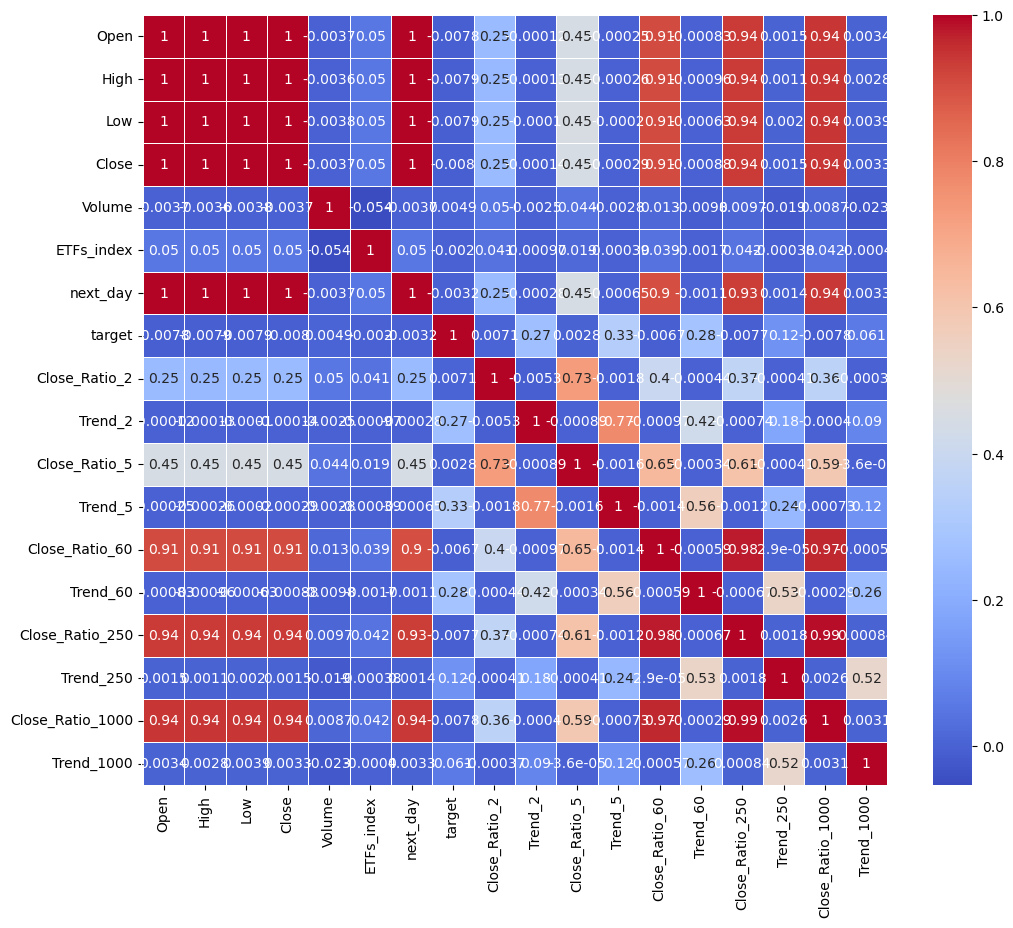

In [84]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()

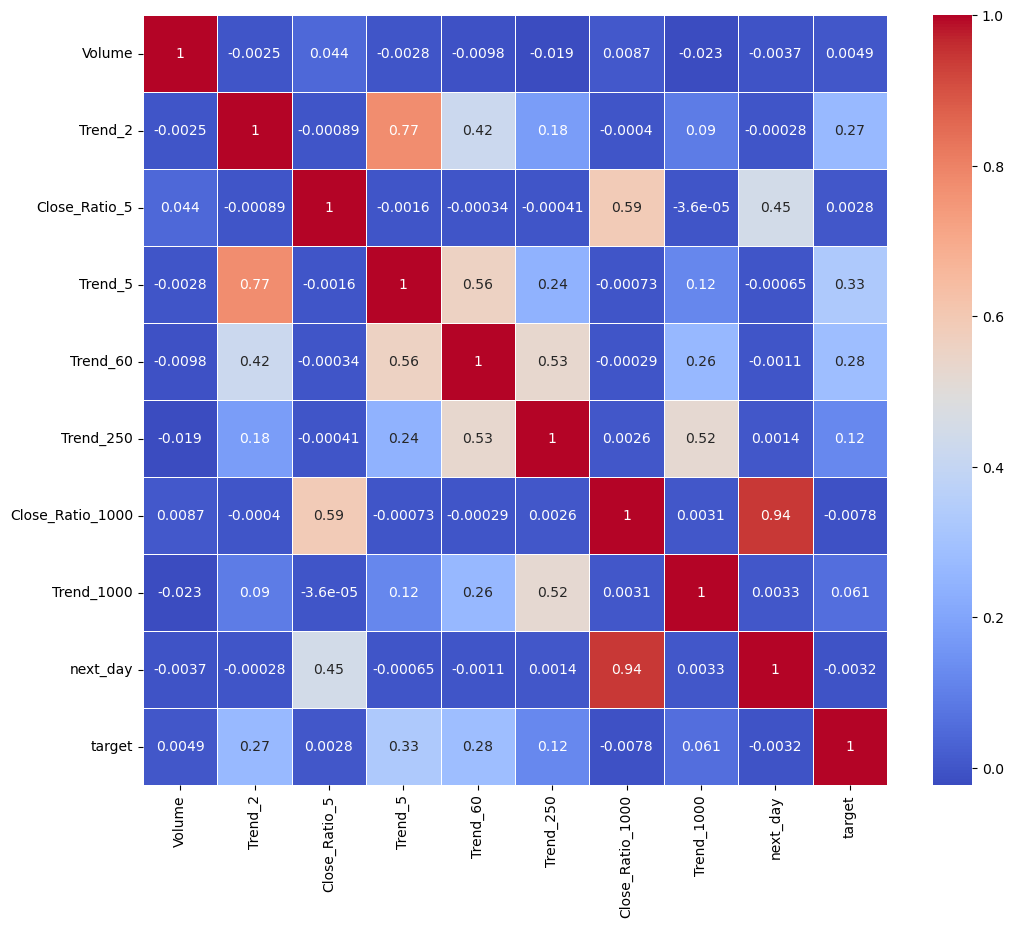

In [85]:
# feature selection

selected_features = ['Volume', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
                     'Trend_60', 'Trend_250', 'Close_Ratio_1000', 
                     'Trend_1000', 'next_day', 'target']

partial_corr_matrix = df[selected_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(partial_corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()


               Open     High     Low    Close    Volume  ETFs_index  next_day  \
Date                                                                            
1999-03-10  45.7220  45.7500  44.967  45.6650  11700414          41    45.880   
1999-03-11  45.9940  46.2600  44.988  45.8800  21670048          41    44.770   
1999-03-12  45.7210  45.7490  44.406  44.7700  19553768          41    46.052   
1999-03-15  45.1010  46.1030  44.625  46.0520  14245348          41    46.447   
1999-03-16  46.2530  46.6430  45.749  46.4470  10971066          41    46.106   
...             ...      ...     ...      ...       ...         ...       ...   
2017-11-10  50.7500  50.7500  50.600  50.6700      5749          30    48.271   
2017-11-10  40.8300  41.3903  40.690  41.3100     55499          29    46.222   
2017-11-10  30.8389  30.9700  30.740  30.9600     22668          28    12.843   
2017-11-10  53.9200  54.1700  53.920  54.0416      5030          92    51.247   
2017-11-10  51.6200  51.7416

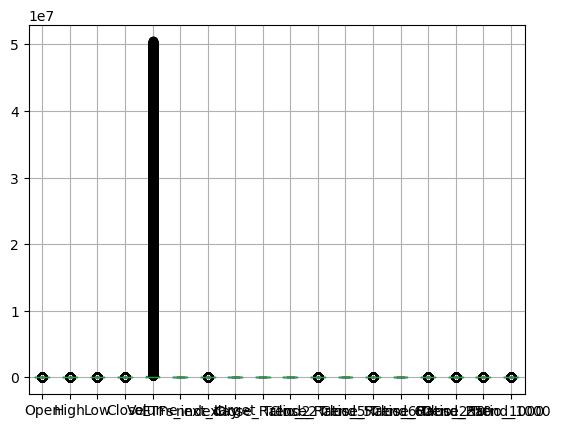

In [86]:
cols = ['Volume']

# print(df.describe())

# detect outliers
z_scores = stats.zscore(df[cols])
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]

print(df)

box_plots = df.boxplot()

In [87]:
df = df.dropna()
print(df)

               Open     High     Low    Close    Volume  ETFs_index  next_day  \
Date                                                                            
2003-05-23  25.0730  25.2590  24.993  25.1250  42410758          41    26.023   
2003-08-15  27.7260  27.9850  27.662  27.8780  31437340          41    28.594   
2003-08-25  28.9390  29.0990  28.804  29.0730  48132290          41    29.101   
2003-11-28  31.5300  31.7420  31.483  31.6370  27737679          41    32.107   
2003-12-24  32.0630  32.2250  32.027  32.1150  50122385          41    32.069   
...             ...      ...     ...      ...       ...         ...       ...   
2017-11-10  50.7500  50.7500  50.600  50.6700      5749          30    48.271   
2017-11-10  40.8300  41.3903  40.690  41.3100     55499          29    46.222   
2017-11-10  30.8389  30.9700  30.740  30.9600     22668          28    12.843   
2017-11-10  53.9200  54.1700  53.920  54.0416      5030          92    51.247   
2017-11-10  51.6200  51.7416

In [88]:
training_size = int(len(df) * 0.7)
test_size = df.shape[0] - training_size

numerical_cols = ['Volume', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Trend_60', 'Trend_250',
                                       'Close_Ratio_1000', 'Trend_1000']

xTrain = df[['Volume', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Trend_60', 'Trend_250', 'Close_Ratio_1000', 
             'Trend_1000']].iloc[:training_size]
xTest = df[['Volume', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Trend_60', 'Trend_250', 'Close_Ratio_1000', 
            'Trend_1000']].iloc[-1 * test_size:]

yTrain_discrete = df["target"].iloc[:training_size]
yTest_discrete = df["target"].iloc[-1 * test_size:]

yTrain_continuous = df["next_day"].iloc[:training_size]
yTest_continuous = df["next_day"].iloc[-1 * test_size:]

scalar1 = StandardScaler()

xTrain[numerical_cols] = scalar1.fit_transform(xTrain[numerical_cols])
xTest[numerical_cols] = scalar1.transform(xTest[numerical_cols])

scalar2 = StandardScaler()

yTrain_continuous = scalar2.fit_transform(yTrain_continuous.values.reshape(-1, 1))
yTest_continuous = scalar2.transform(yTest_continuous.values.reshape(-1, 1))

# scaler3 = MinMaxScaler()
# xTrain['ETFs_index'] = scaler3.fit_transform(xTrain['ETFs_index'].values.reshape(-1, 1))
# xTest['ETFs_index'] = scaler3.transform(xTest['ETFs_index'].values.reshape(-1, 1))

pd.DataFrame(xTrain, columns=['Volume', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Trend_60', 'Trend_250', 'Close_Ratio_1000', 
            'Trend_1000']).to_csv("newData/xTrain.csv", index=False)
pd.DataFrame(xTest, columns=['Volume', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Trend_60', 'Trend_250', 'Close_Ratio_1000', 
            'Trend_1000']).to_csv("newData/xTest.csv", index=False)

pd.DataFrame(yTrain_discrete).to_csv("newData/yTrain_discrete.csv", index=False)
pd.DataFrame(yTest_discrete).to_csv("newData/yTest_discrete.csv", index=False)
pd.DataFrame(yTrain_continuous, columns=["target"]).to_csv("newData/yTrain_continuous.csv", index=False)
pd.DataFrame(yTest_continuous, columns=["target"]).to_csv("newData/yTest_continuous.csv", index=False)


print(xTrain)
print(xTest)

               Volume   Trend_2  Close_Ratio_5   Trend_5  Trend_60  Trend_250  \
Date                                                                            
2003-05-23  10.611777  1.244263       0.016321  0.281600  0.267511  -0.124965   
2003-08-15   7.805703  1.244263       0.019933  1.592606  0.352461   0.121126   
2003-08-25  12.074862 -0.036005       0.006996  0.281600  0.182561   0.156282   
2003-11-28   6.859642  1.244263       0.017402  0.937103  0.097611   0.296905   
2003-12-24  12.583760  1.244263       0.014219  0.937103  0.437412   0.402373   
...               ...       ...            ...       ...       ...        ...   
2015-07-16   0.254286 -0.036005      -0.145442 -0.373903 -1.006743  -0.511679   
2015-07-16  -0.233208 -0.036005       0.153533 -0.373903 -1.006743  -0.511679   
2015-07-16  -0.174804 -1.316274      -0.210884 -1.029405 -1.006743  -0.511679   
2015-07-16  -0.189839 -0.036005      -0.952977 -0.373903 -0.921793  -0.476523   
2015-07-16  -0.227630 -0.036

In [89]:
print(yTrain_discrete)

Date
2003-05-23    1
2003-08-15    1
2003-08-25    1
2003-11-28    1
2003-12-24    0
             ..
2015-07-16    0
2015-07-16    0
2015-07-16    1
2015-07-16    0
2015-07-16    1
Name: target, Length: 127369, dtype: int64


In [90]:
print(df.isnull().sum())

Open                0
High                0
Low                 0
Close               0
Volume              0
ETFs_index          0
next_day            0
target              0
Close_Ratio_2       0
Trend_2             0
Close_Ratio_5       0
Trend_5             0
Close_Ratio_60      0
Trend_60            0
Close_Ratio_250     0
Trend_250           0
Close_Ratio_1000    0
Trend_1000          0
dtype: int64
